In [2]:
import pandas as pd

# Load the provided Excel file to examine its contents
file_path = 'SAT7HL.xlsx'
xls = pd.ExcelFile(file_path)

# Check the sheet names to identify where the "Tidy" data is located
xls.sheet_names


# Load the 'Tidy' sheet to analyze the data
df_tidy = pd.read_excel(file_path, sheet_name='tidy')

# Display the first few rows of the dataset to understand its structure
df_tidy.head()

,Animal_ID,Phenotype,Stimulus_Duration,Block_Number,CR,FA,HITS,MISS,OM
0,377,ST,0,Bloc1,17.0,2.0,NaN,NaN,0.0
1,377,ST,0,Bloc2,18.0,1.0,NaN,NaN,1.0
2,377,ST,0,Bloc3,18.0,3.0,NaN,NaN,0.0
3,377,ST,0,Bloc4,17.0,3.0,NaN,NaN,1.0
4,377,ST,0,Bloc5,12.0,6.0,NaN,NaN,1.0


In [3]:
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from statsmodels.stats.anova import AnovaRM

# Filter data to include only rows with non-null 'HITS' values
hits_data = df_tidy.dropna(subset=["MISS"])

# Prepare the data for the mixed-design ANOVA
# We need to convert "Block_Number" into a numeric value for the repeated measures factor
hits_data["Block_Number"] = hits_data["Block_Number"].str.extract('(\d)').astype(int)



# Convert Phenotype and Stimulus_Duration to categorical types for the model
hits_data["Phenotype"] = hits_data["Phenotype"].astype("category")
hits_data["Stimulus_Duration"] = hits_data["Stimulus_Duration"].astype("category")

# Fit a mixed-effects linear model using 'HITS' as the dependent variable
# with Block_Number as a within-subject (random effect), and Phenotype and Stimulus_Duration as fixed effects
mixed_model = mixedlm(
    "MISS ~ Phenotype * Block_Number",
    data=hits_data,
    groups=hits_data["Animal_ID"],
    re_formula="~Block_Number"
)

# Fit the model
mixed_model_results = mixed_model.fit()

# Display the summary of the mixed-effects model
mixed_model_results.summary()


C:\Users\pfh3221\AppData\Local\Temp\ipykernel_14212\1280481007.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hits_data["Block_Number"] = hits_data["Block_Number"].str.extract('(\d)').astype(int)
C:\Users\pfh3221\AppData\Local\Temp\ipykernel_14212\1280481007.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hits_data["Phenotype"] = hits_data["Phenotype"].astype("category")
C:\Users\pfh3221\AppData\Local\Temp\ipykernel_14212\1280481007.py:16: SettingWithCopyWarning: 
A value is trying to be set on a

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:                 MixedLM      Dependent Variable:      MISS      
No. Observations:      630          Method:                  REML      
No. Groups:            42           Scale:                   1.9158    
Min. group size:       15           Log-Likelihood:          -1201.2963
Max. group size:       15           Converged:               No        
Mean group size:       15.0                                            
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     0.533    0.301  1.771 0.077 -0.057  1.124
Phenotype[T.IN]               0.231    0.389  0.593 0.553 -0.532  0.993
Phenotype[T.ST]               0.494    0.352  1.404 0.160 -0.195  1.183
Block_Number                  0.408    0.452  0.903 0.367 -0.478  1.295
Phenotype[T.IN]:Block_Number -0.122    0.584 -0.209 0.834 -1.267  1.022
Phenotype[T.ST]:Block_Number -0.130    0.528 -0.245 0.806 -1.165  0.906
Group Var                     0.023    0.097                           
Group x Block_Number Cov     -0.042    0.201                           
Block_Number Var              1.572                                    
=======================================================================

"""

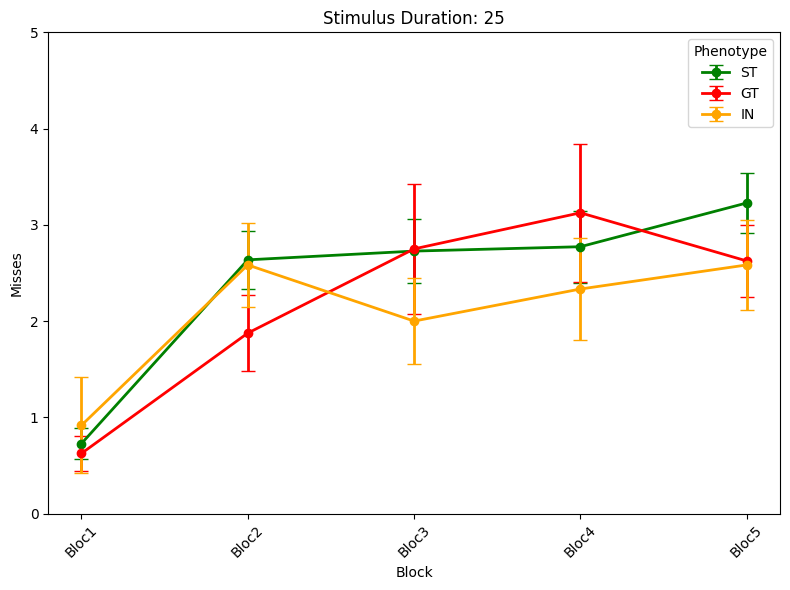

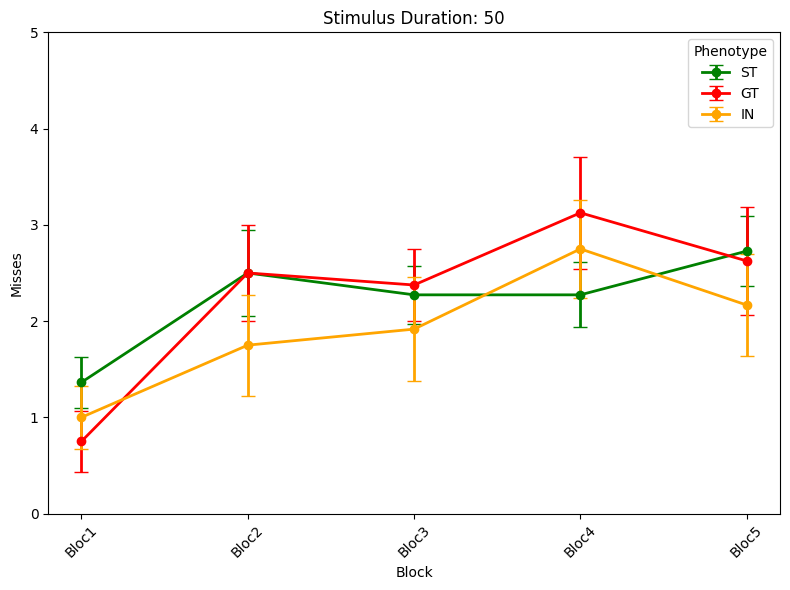

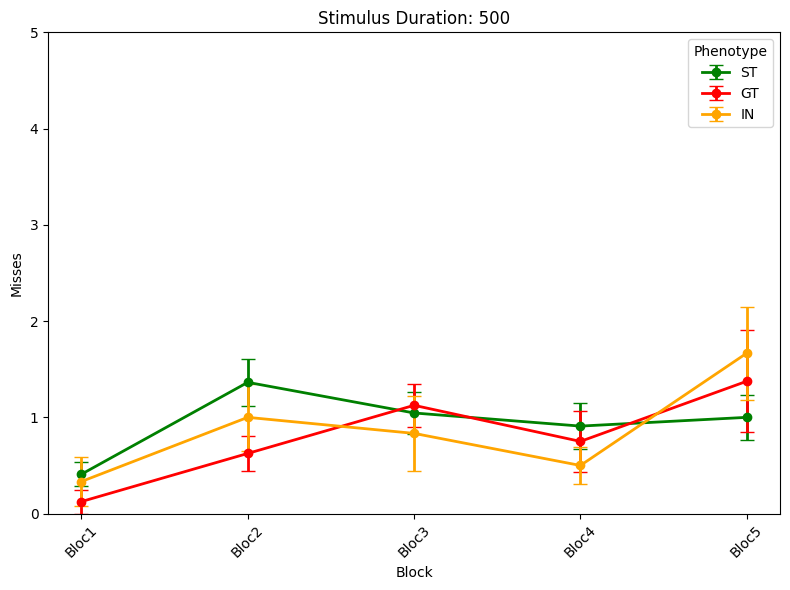

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load your data (assuming the file is already loaded)
file_path = 'SAT7HL.xlsx'
tidy_data = pd.read_excel(file_path, sheet_name='tidy')

# Filtering the data to remove NaN values in 'MISS'
tidy_data_miss = tidy_data.dropna(subset=['MISS'])

# Reshaping the data so each Block (Bloc1, Bloc2, ...) becomes a column (wide format)
misses_wide = tidy_data_miss.pivot_table(index=['Animal_ID', 'Phenotype', 'Stimulus_Duration'],
                                         columns='Block_Number', values='MISS').reset_index()

# Renaming columns for easier reference
misses_wide.columns = ['Animal_ID', 'Phenotype', 'Stimulus_Duration', 'Bloc1', 'Bloc2', 'Bloc3', 'Bloc4', 'Bloc5']

# Reshaping back to long format for ANOVA
misses_long = pd.melt(misses_wide, id_vars=['Animal_ID', 'Phenotype', 'Stimulus_Duration'],
                      value_vars=['Bloc1', 'Bloc2', 'Bloc3', 'Bloc4', 'Bloc5'],
                      var_name='Block', value_name='Misses')

# Grouping the data by Phenotype, Stimulus_Duration, and Block to calculate the means and SEM
means = misses_long.groupby(['Phenotype', 'Stimulus_Duration', 'Block']).Misses.mean().reset_index()
sems = misses_long.groupby(['Phenotype', 'Stimulus_Duration', 'Block']).Misses.sem().reset_index()

# Merging means and SEMs into a single dataframe
plot_data = pd.merge(means, sems, on=['Phenotype', 'Stimulus_Duration', 'Block'], suffixes=('_mean', '_sem'))

# Creating colors for the phenotypes
colors = {'ST': 'green', 'GT': 'red', 'IN': 'orange'}

# Unique stimulus durations for separate plots
stimulus_durations = plot_data['Stimulus_Duration'].unique()

# Plotting each stimulus duration separately
for stim in stimulus_durations:
    plt.figure(figsize=(8, 6))
    
    for phenotype in colors.keys():
        subset = plot_data[(plot_data['Stimulus_Duration'] == stim) & (plot_data['Phenotype'] == phenotype)]
        blocks = np.arange(len(subset['Block']))
        
        # Plotting the means with SEM
        plt.errorbar(blocks, subset['Misses_mean'], yerr=subset['Misses_sem'], label=phenotype,
                     color=colors[phenotype], capsize=5, marker='o', linestyle='-', linewidth=2)

    plt.xticks(blocks, subset['Block'], rotation=45)
    plt.ylim([0, 5])
    plt.xlabel('Block')
    plt.ylabel('Misses')
    plt.title(f'Stimulus Duration: {stim}')
    plt.legend(title='Phenotype')
    plt.tight_layout()
    
    # Show the plot for each stimulus duration
    plt.show()


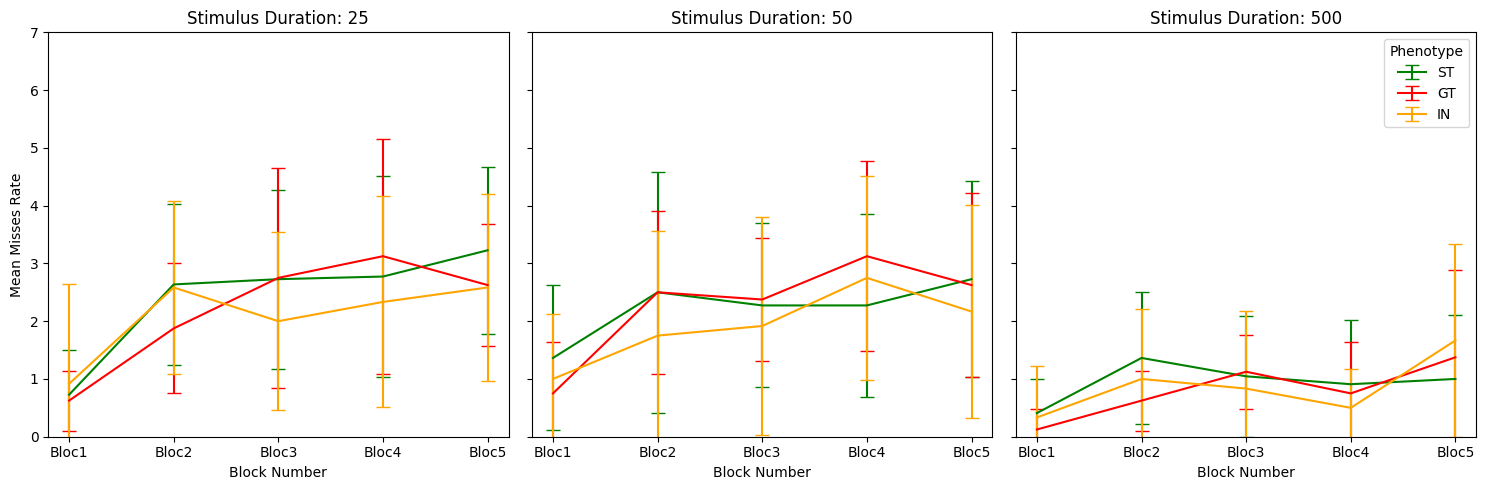

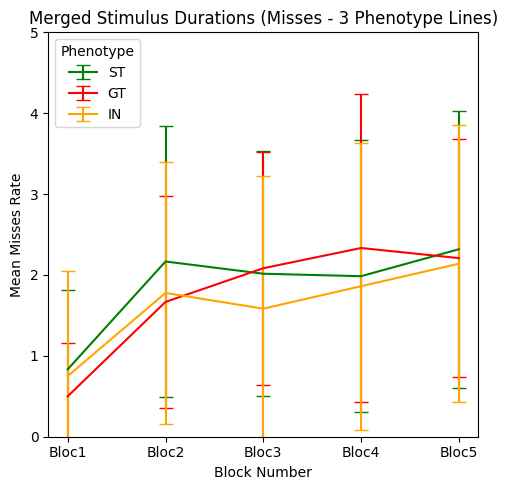

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the spreadsheet
file_path = 'SAT7HL.xlsx'
xls = pd.ExcelFile(file_path)

# Load the data from the 'tidy' sheet
tidy_df = pd.read_excel(xls, sheet_name='tidy')

# Filter out NaN in 'MISS' as we are focusing on that metric
tidy_filtered = tidy_df.dropna(subset=['MISS'])

# Get unique stimulus durations and phenotypes
stimulus_durations = tidy_filtered['Stimulus_Duration'].unique()
phenotypes = tidy_filtered['Phenotype'].unique()

# Define colors for phenotypes
phenotype_colors = {'ST': 'green', 'IN': 'orange', 'GT': 'red'}

# Group by Stimulus_Duration, Block_Number, and Phenotype, then calculate mean and std for MISS
grouped_data_miss = tidy_filtered.groupby(['Stimulus_Duration', 'Block_Number', 'Phenotype']).agg(
    mean_miss=('MISS', 'mean'),
    std_miss=('MISS', 'std')
).reset_index()

# Set the figure for 3 side-by-side plots for 'MISS'
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Set common y-axis limits based on the data for 'MISS'
y_min_miss, y_max_miss = tidy_filtered['MISS'].min(), tidy_filtered['MISS'].max()

# Plot each stimulus duration for MISS
for ax, stimulus_duration in zip(axes, stimulus_durations):
    for phenotype in phenotypes:
        # Filter data by stimulus duration and phenotype
        data = grouped_data_miss[(grouped_data_miss['Stimulus_Duration'] == stimulus_duration) & 
                                 (grouped_data_miss['Phenotype'] == phenotype)]
        ax.errorbar(data['Block_Number'], data['mean_miss'], yerr=data['std_miss'], 
                    label=phenotype, color=phenotype_colors[phenotype], capsize=5)

    ax.set_title(f'Stimulus Duration: {stimulus_duration}')
    ax.set_xlabel('Block Number')
    ax.set_ylim(y_min_miss, y_max_miss)

axes[0].set_ylabel('Mean Misses Rate')
plt.legend(title='Phenotype')

# Show the side-by-side plots for MISS
plt.tight_layout()
plt.show()

# Now, let's generate the merged plot (all stimulus durations combined) for MISS

# Group by Block_Number and Phenotype to merge across stimulus durations for MISS
merged_data_miss = tidy_filtered.groupby(['Block_Number', 'Phenotype']).agg(
    mean_miss=('MISS', 'mean'),
    std_miss=('MISS', 'std')
).reset_index()

# Plot the merged data with mean and std across all stimulus durations for MISS
plt.figure(figsize=(5, 5))

for phenotype in phenotypes:
    data = merged_data_miss[merged_data_miss['Phenotype'] == phenotype]
    plt.errorbar(data['Block_Number'], data['mean_miss'], yerr=data['std_miss'], 
                 label=phenotype, color=phenotype_colors[phenotype], capsize=5)

plt.title('Merged Stimulus Durations (Misses - 3 Phenotype Lines)')
plt.xlabel('Block Number')
plt.ylabel('Mean Misses Rate')
plt.ylim(0, 5)#(y_min_miss, y_max_miss)
plt.legend(title='Phenotype')
plt.tight_layout()
plt.show()
